In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad_vec
from scipy.linalg import expm, inv
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
def phi_A(t_1, t_2, A):
    return expm(A*(t_2-t_1))

def integrand(tau, t1, A, B):
    phi_tau = phi_A(t1, tau, A)
    return phi_tau @ B @ B.T @ phi_tau.T 

def M(t0, t1, A, B):
    # Define the integrand as a function of tau, the variable of integration
    def integrand(tau):
        phi_tau = phi_A(t1, tau, A)
        return phi_tau @ B @ B.T @ phi_tau.T

    # Initialize the matrix to be returned
    M_matrix = np.zeros((2, 2))

    # Integrate each element of the matrix using quad_vec
    for i in range(2):
        for j in range(2):
            # Define a lambda function for the current element
            element_integrand = lambda tau: integrand(tau)[i, j]
            # Perform the integration for the current element
            M_matrix[i, j], _ = quad_vec(element_integrand, t0, t1)
    return M_matrix

def P_0(Q0, Sigma_0_inv):
    return inv((Sigma_0_inv - inv(Q0)))

def P_T(T, P0, A, B):
    return phi_A(T, 0, A) @ P0 @ phi_A(T, 0, A).T + M(T, 0, A, B)

def Q_T(PT, Sigma_T_inv):
    return inv((Sigma_T_inv - inv(PT)))

def Q_0(T, QT, A, B):
    return phi_A(0, T, A) @ (QT + M(T, 0, A, B)) @ phi_A(0, T, A).T

# System parameters for inertial particles
# A(t) = [[0, 1], [0, 0]] for the system dx = v*dt, dv = u*dt + dw
# B(t) = [[0], [1]] since the control input u(t) only affects the acceleration
A_const = np.array([[0, 1], [0, 0]])
B_const = np.array([[0], [1]])

# Initial and terminal inverse covariance matrices for the Gaussian distributions
# Sigma_0 = I implies Sigma_0_inv = I
# Sigma_T = 1/4*I implies Sigma_T_inv = 4*I
Sigma_0_inv = np.eye(2)
Sigma_T_inv = 4*np.eye(2)

# Time span
T = 1  # Terminal time
t_span = (0, T)
t_eval = np.linspace(0, T, 100)  # Adjust the number of points as needed

Q0 = 2*np.eye(2)

# Example usage
M_example = M(0, 1, A_const, B_const)
M_example

for i in range(100):
    P0 = P_0(Q0, Sigma_0_inv)
    PT = P_T(T, P0, A_const, B_const)
    QT = Q_T(PT, Sigma_T_inv)
    Q0 = Q_0(T, QT, A_const, B_const)

print("P0=", P0)
print("PT=", PT)
print("QT=", QT)
print("Q0=", Q0)

P0= [[0.52294892 0.32763652]
 [0.32763652 0.23208009]]
PT= [[-0.23357736 -0.40444357]
 [-0.40444357 -0.76791991]]
QT= [[0.05643107 0.0769095 ]
 [0.0769095  0.15804232]]
Q0= [[-1.96504095 -1.26504818]
 [-1.26504818 -0.84195768]]


In [3]:
tolerance = 1e-3
assert np.allclose(inv(P0)+inv(Q0), Sigma_0_inv, atol=tolerance) 
assert np.allclose(inv(PT)+inv(QT), Sigma_T_inv, atol=tolerance) 

In [4]:
# The system of differential equations for Q
def system_Q(t, Q_flat, A, B):
    Q = Q_flat.reshape(A.shape)
    Q_dot = A @ Q + Q @ A.T - B @ B.T
    return Q_dot.flatten()

# The system of differential equations for P
def system_P(t, P_flat, A, B):
    P = P_flat.reshape(A.shape)
    P_dot = A @ P + P @ A.T + B @ B.T
    return P_dot.flatten()

# Residual function for the shooting method for Q
def residuals_Q(Q0_flat, Q_T_target, A, B, t_span):
    sol = solve_ivp(system_Q, t_span, Q0_flat, args=(A, B), method='RK45', dense_output=True)
    Q_final = sol.sol(t_span[1]).reshape(A.shape)
    res = Q_final - Q_T_target
    return res.flatten()

# Residual function for the shooting method for P
def residuals_P(P0_flat, P_T_target, A, B, t_span):
    sol = solve_ivp(system_P, t_span, P0_flat, args=(A, B), method='RK45', dense_output=True)
    P_final = sol.sol(t_span[1]).reshape(A.shape)
    res = P_final - P_T_target
    return res.flatten()

# Flatten the terminal matrices for use in fsolve
QT_target_flat = QT.flatten()
PT_target_flat = PT.flatten()

# Find the root of the residuals function for Q
Q0_opt_flat = fsolve(residuals_Q, Q0.flatten(), args=(QT, A_const, B_const, t_span))

# Find the root of the residuals function for P
P0_opt_flat = fsolve(residuals_P, P0.flatten(), args=(PT, A_const, B_const, t_span))

# Solve the IVP with the optimized initial conditions for Q
solution_Q = solve_ivp(system_Q, t_span, Q0_opt_flat, args=(A_const, B_const), method='RK45', t_eval=t_eval)

# Solve the IVP with the optimized initial conditions for P
solution_P = solve_ivp(system_P, t_span, P0_opt_flat, args=(A_const, B_const), method='RK45', t_eval=t_eval)

# Reshape the solutions into matrix form for analysis
Q_t_opt = solution_Q.y.reshape(2, 2, -1)
P_t_opt = solution_P.y.reshape(2, 2, -1)

# Final optimized matrices
Q_final_opt = Q_t_opt[:, :, -1]
P_final_opt = P_t_opt[:, :, -1]

Q_final_opt, P_final_opt

print(np.shape(Q_t_opt))

(2, 2, 100)


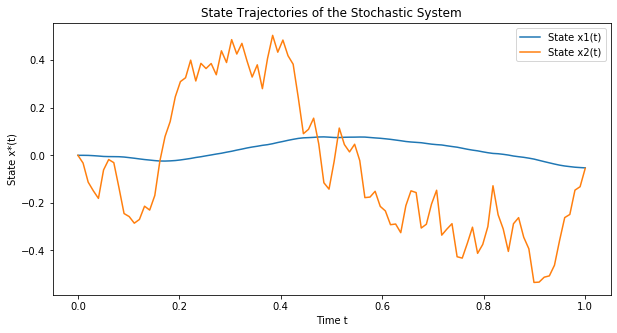

In [5]:
# Assuming the initial state is the zero vector
xi = np.array([0, 0])

# Number of simulation steps
N = len(t_eval)
dt = 1/N  # time increment

# Preallocate arrays to hold the simulation results
x_star_traj = np.zeros((2, N))
x_star_traj[:, 0] = xi  # Set initial condition

# Function to compute the control input within the SDE
def feedback_control(t, x, Q_t_func, B):
    Q_inv = inv(Q_t_func.reshape(2,2))
    return -B @ B.T @ Q_inv @ x

# Simulate the SDE using Euler-Maruyama method
for i in range(1, N):
    t = t_eval[i-1]
    dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
    feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
    x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw

# Plot the trajectories of state x1 and x2
plt.figure(figsize=(10, 5))
plt.plot(t_eval, x_star_traj[0, :], label='State x1(t)')
plt.plot(t_eval, x_star_traj[1, :], label='State x2(t)')
plt.xlabel('Time t')
plt.ylabel('State x*(t)')
plt.title('State Trajectories of the Stochastic System')
plt.legend()
plt.show()

In [6]:
import numpy as np
import plotly.graph_objects as go

# Define simulation parameters
num_simulations = 10  # Number of simulations
N = len(t_eval)
dt = 1 / N  # time increment

# Create a figure for the 3D plot
fig = go.Figure()

# Loop for different random initializations
for sim_num in range(num_simulations):
    # Generate a random initial condition xi with the specified density
    xi = np.random.multivariate_normal(mean=np.zeros(2), cov=inv(Sigma_0_inv))
    
    # Preallocate arrays to hold the simulation results
    x_star_traj = np.zeros((2, N))
    x_star_traj[:, 0] = xi  # Set initial condition
    
    # Simulate the SDE using Euler-Maruyama method
    for i in range(1, N):
        t = t_eval[i-1]
        dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
        feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
        x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw
    
    # Store the trajectory data for the 3D plot
    time = np.arange(0, N) * dt
    state_1 = x_star_traj[0, :]
    state_2 = x_star_traj[1, :]
    
    fig.add_trace(go.Scatter3d(x=time, y=state_1, z=state_2, mode='lines', name=f'Simulation {sim_num+1}'))

# Set axis labels and title
fig.update_layout(scene=dict(xaxis_title='Time t', yaxis_title='x(t)', zaxis_title='v(t)'),
                  title='State Trajectories of the Stochastic System (3D Plot)')

# Set axis labels and title
fig.update_layout(scene=dict(xaxis_title='Time t', yaxis_title='x(t)', zaxis_title='v(t)',
                    xaxis = dict(nticks=5, range=[0,1],),
                    yaxis = dict(nticks=5, range=[-5,5],),
                    zaxis = dict(nticks=5, range=[-4,4])),
                  title='State Trajectories of the Stochastic System (3D Plot)'), 

# Show the 3D plot
fig.show()
